# Credit Card Analysis of Adobo Advantage Cards (AAC)

### Looking at their Customers and their Spending Behaviors

## 0. Notebook Overview

### Objectives

The main objective of this project is to gather information about AAC's customers based on their transaction history and suggest actionable steps the business can take to maintain or improve their customer's spending behaviors.

### About the Dataset

### Table of Contents
0. Notebook Overview
1. Cleaning the Dataset
2. Exploratory Data Analysis
3. Clustering using K Means
4. Cluster Deep Dive

### Imports

In [2]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## 1. Cleaning the Dataset

This section will focus on cleaning the dataset to ensure that it can be used for further analysis.

We first load the dataset obtained from Eskwelabs

In [3]:
df = pd.read_csv("cc_dirty.csv")

Looking at the first few rows of the dataset...

In [4]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4.870000e+15,M,San Fernando,"121,812 people",NaN,18/07/1964,NaN,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


In [5]:
display(df.info(),
        df.nunique(),
        df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  float64
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  object 
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   103427 non-null  float64
 7   acct_num2  111877 non-null  int64  
 8   trans_num  111877 non-null  object 
 9   unix_time  111877 non-null  int64  
 10  category   103318 non-null  object 
 11  amt        111877 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 10.2+ MB


None

cc_num           69
gender            4
city             59
city_pop         60
job              90
dob              93
acct_num         94
acct_num2        89
trans_num    100000
unix_time     99881
category         14
amt           19963
dtype: int64

cc_num          0
gender          0
city            0
city_pop        0
job          8450
dob             0
acct_num     8450
acct_num2       0
trans_num       0
unix_time       0
category     8559
amt             0
dtype: int64

From the information above, it was observed that
1. `city_pop` is a string instead of an integer
2. `gender` has 4 unique categories (should only be 2)
3. `unix_time` is an integer type and is not easily understandable
4. there are some null values in `job`, `acct_num`, and `category`
5. `amt` is a string because it contains the character "$"
6. `dob` is a string instead of a date
7. there are only 100,000 unique transactions (`trans_num`) but we have a total of 111877 rows

To begin the data cleaning, we will be dropping the duplicate rows and rows with null values (if they have no `job`). For the category, the null values will be replaced with `no_category`.

In [6]:
df = df[~df['job'].isna()] # remove columns with null job values (or acct num)
df.drop_duplicates(inplace=True) # drop duplicates
df.fillna({"category": "no_category"}, inplace=True) # replace empty in category

display(df.head(),
        df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 92432 entries, 0 to 111875
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cc_num     92432 non-null  float64
 1   gender     92432 non-null  object 
 2   city       92432 non-null  object 
 3   city_pop   92432 non-null  object 
 4   job        92432 non-null  object 
 5   dob        92432 non-null  object 
 6   acct_num   92432 non-null  float64
 7   acct_num2  92432 non-null  int64  
 8   trans_num  92432 non-null  object 
 9   unix_time  92432 non-null  int64  
 10  category   92432 non-null  object 
 11  amt        92432 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 9.2+ MB


,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
4,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69
5,3.530000e+15,Male,City of Paranaque,"665,822 people","Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,$363.49


None

We then standardize the `gender` column to only contain either `F` for female or `M` for male

In [7]:
df['gender'].value_counts()

gender
M         60983
Male      26180
F          3144
Female     2125
Name: count, dtype: int64

In [8]:
df['gender'] = df['gender'].map({"Male": "M", "Female": "F", "M": "M", "F": "F"})
df.gender.value_counts()

gender
M    87163
F     5269
Name: count, dtype: int64

For the `amt` column, the dollar ($) sign was removed and then was converted so that mathematical computations can be done to the dataset.

In [9]:
df['amt'] = df['amt'].str.replace("$", "").astype(float)

For the `city_pop` column, the word "people" and the comma were removed and the values were then converted to an integer type

In [10]:
df['city_pop'] = df['city_pop'].str.replace("people", "").str.replace(",", "").astype(int)

In [11]:
display(df.head(),
        df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 92432 entries, 0 to 111875
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cc_num     92432 non-null  float64
 1   gender     92432 non-null  object 
 2   city       92432 non-null  object 
 3   city_pop   92432 non-null  int32  
 4   job        92432 non-null  object 
 5   dob        92432 non-null  object 
 6   acct_num   92432 non-null  float64
 7   acct_num2  92432 non-null  int64  
 8   trans_num  92432 non-null  object 
 9   unix_time  92432 non-null  int64  
 10  category   92432 non-null  object 
 11  amt        92432 non-null  float64
dtypes: float64(3), int32(1), int64(2), object(6)
memory usage: 8.8+ MB


,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69
5,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49


None

The `dob` column and `unix_time` were converted into datetime format. For `unix_time`, it was first converted to a readable system and then formatted.

In [12]:
# Converting to readable system
df['trans_datetime'] = pd.to_datetime(df['unix_time'], unit='s', utc=True)

# Format to yyyy-mm-dd hh:mm:ss
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S'))

df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 05:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 05:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 05:52:37
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 08:35:59
5,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 04:33:50


Converting `dob`

In [13]:
df['trans_dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime,trans_dob
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 05:53:31,1958-12-12
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 05:29:28,1970-08-31
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 05:52:37,1953-07-23
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 08:35:59,1954-01-11
5,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 04:33:50,1961-07-31


Lastly, we add some columns that will be useful for analysis later. Specifically, we get the `age` and the specifics of each transaction (i.e. the year, month, hour, and elapsed days). For the age, we assume that the current year is 2022.

In [14]:
df['age'] = (pd.to_datetime('2022-01-01') - df['trans_dob']) // pd.Timedelta(days=365.25)

Using the `trans_dob` to get which generation each holder is in
- Lost Gen: 1883-1900
- Greatest Gen: 1901-1927
- Silent Gen: 1928-1945
- Baby Boomers: 1946-1964
- Generation X: 1965-1980
- Millenials: 1981-1996
- Gen Z: 1998-2012
- Gen Alpha: 2013 - present

In [15]:
# Grouping based on the generation
bins = [-np.Inf, 1927, 1945, 1964, 1980, 1996, 2012, np.Inf]
labels = ['Greatest Generation', 'Silent Generation', 'Baby Boomers',
          'Generation X', 'Millenials', 'Generation Z', 'Generation Alpha']

df['generation'] = pd.cut(df['trans_dob'].dt.year, bins=bins,
                          right=True, labels=labels)

In [16]:
# Getting hour of transaction
df['trans_hour'] = df['trans_datetime'].dt.hour

# Getting month of transaction
df['trans_month'] = df['trans_datetime'].dt.month

# Getting year of transaction
df['trans_year'] = df['trans_datetime'].dt.year

# Getting days elapsed (passed) since date of transaction to Jan 01, 2022
df['elapsed_days'] = (pd.to_datetime('2022-01-01') - df['trans_datetime']).dt.days

In [17]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime,trans_dob,age,generation,trans_hour,trans_month,trans_year,elapsed_days
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 05:53:31,1958-12-12,63,Baby Boomers,5,2,2020,690
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 05:29:28,1970-08-31,51,Generation X,5,5,2020,579
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 05:52:37,1953-07-23,68,Baby Boomers,5,3,2020,642
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 08:35:59,1954-01-11,67,Baby Boomers,8,9,2020,459
5,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 04:33:50,1961-07-31,60,Baby Boomers,4,7,2020,532


In [18]:
df.dtypes

cc_num                   float64
gender                    object
city                      object
city_pop                   int32
job                       object
dob                       object
acct_num                 float64
acct_num2                  int64
trans_num                 object
unix_time                  int64
category                  object
amt                      float64
trans_datetime    datetime64[ns]
trans_dob         datetime64[ns]
age                        int64
generation              category
trans_hour                 int32
trans_month                int32
trans_year                 int32
elapsed_days               int64
dtype: object

## 2. Exploratory Data Analysis

Doing an initial exploration of the data. Specifically, we look at
1. timeline of the transaction (start and end period)
2. number of account holders (customers)
3. gender distribution of customers
4. age distribution of customers (based on generation)
5. city distribution of customers
6. categories with the most number of transactions
7. categories with the highest amount spent

Timeline of transaction history

In [19]:
display(df['trans_datetime'].min(),
        df['trans_datetime'].max())

Timestamp('2020-01-01 00:06:15')

Timestamp('2021-12-06 23:50:42')

Number of account holders

In [20]:
display(df['acct_num'].nunique())

94

Getting information about the unique holders

In [21]:
unique_holders = df.drop_duplicates(subset=['acct_num']).reset_index()
unique_holders = unique_holders.drop(columns=['index', 'cc_num', 'trans_num', 'category', 'amt', 'unix_time', 'trans_datetime', 'trans_hour',
                                              'trans_month', 'trans_year', 'elapsed_days'], axis=1)
unique_holders

,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_dob,age,generation
0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,1958-12-12,63,Baby Boomers
1,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,1970-08-31,51,Generation X
2,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,1953-07-23,68,Baby Boomers
3,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,1954-01-11,67,Baby Boomers
4,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,1961-07-31,60,Baby Boomers
...,...,...,...,...,...,...,...,...,...,...
89,M,Iloilo,447992,Land/geomatics surveyor,10/04/1969,1.690000e+11,169000000000,1969-04-10,52,Generation X
90,M,Lucena,266248,Interpreter,01/06/1957,9.600000e+11,960000000000,1957-06-01,64,Baby Boomers
91,M,Pagadian,199060,Land/geomatics surveyor,14/09/1961,2.360000e+11,236000000000,1961-09-14,60,Baby Boomers
92,M,Marikina City,450741,Youth worker,05/09/1954,1.380000e+11,138000000000,1954-09-05,67,Baby Boomers


Gender distribution of customers

In [22]:
# display(df.groupby('gender')['acct_num'].nunique())

display(unique_holders['gender'].value_counts(),
        unique_holders['gender'].value_counts(1).map(lambda x: x*100))

gender
M    88
F     6
Name: count, dtype: int64

gender
M    93.617021
F     6.382979
Name: proportion, dtype: float64

In [90]:
gender_count = unique_holders['gender'].value_counts().to_frame(name="count").reset_index()
fig = px.bar(gender_count, x='gender', y='count', color='gender')
fig.show()

Age distribution (based on generation)

In [23]:
# df.groupby('generation')['acct_num'].nunique()

display(unique_holders['generation'].value_counts(),
        unique_holders['generation'].value_counts(1).map(lambda x: x*100))

generation
Baby Boomers           55
Generation X           19
Silent Generation      17
Greatest Generation     3
Millenials              0
Generation Z            0
Generation Alpha        0
Name: count, dtype: int64

generation
Baby Boomers           58.510638
Generation X           20.212766
Silent Generation      18.085106
Greatest Generation     3.191489
Millenials              0.000000
Generation Z            0.000000
Generation Alpha        0.000000
Name: proportion, dtype: float64

In [97]:
generation_count = unique_holders['generation'].value_counts().to_frame(name="count").reset_index()
generation_count = generation_count[generation_count['count'] > 0]
fig = px.bar(generation_count, x='generation', y='count', color='generation')
fig.show()

In [24]:
display(unique_holders['age'].describe())

count    94.000000
mean     66.957447
std      11.538542
min      51.000000
25%      58.000000
50%      64.500000
75%      73.000000
max      95.000000
Name: age, dtype: float64

City distribution of customers

In [25]:
display(unique_holders['city'].value_counts()[0:5],
        unique_holders['city'].value_counts(1).map(lambda x: x*100)[0:5])

city
San Fernando    5
Dasmarinas      4
Calapan         4
Masbate         3
Pagadian        3
Name: count, dtype: int64

city
San Fernando    5.319149
Dasmarinas      4.255319
Calapan         4.255319
Masbate         3.191489
Pagadian        3.191489
Name: proportion, dtype: float64

In [112]:
top_city_count = unique_holders['city'].value_counts().to_frame(name="count").reset_index()
fig = px.bar(top_city_count, x='count', y='city', color='city')
fig.show()

In [98]:
top_city_count = unique_holders['city'].value_counts()[0:5].to_frame(name="count").reset_index()
fig = px.bar(top_city_count, x='city', y='count', color='city')
fig.show()

Categories with the most number of transactions

In [26]:
df.groupby('category')['trans_datetime'].count().sort_values(ascending=False)

category
grocery_pos       8686
shopping_pos      8660
gas_transport     8617
kids_pets         8495
home              8397
no_category       7041
personal_care     6887
food_dining       6726
entertainment     6569
misc_pos          5627
health_fitness    4654
shopping_net      4308
travel            3438
misc_net          2874
grocery_net       1453
Name: trans_datetime, dtype: int64

In [110]:
category_names = {"grocery_pos": "Physical Grocery",
                  "shopping_pos": "Physical Shopping",
                  "gas_transport": "Gas and Transportation",
                  "kids_pets": "Kids and Pets",
                  "home": "Home",
                  "no_category": "No Category",
                  "personal_care": "Personal Care",
                  "food_dining": "Food and Dining",
                  "entertainment": "Entertainment",
                  "misc_pos": "Physical Miscellaneous",
                  "health_fitness": "Health and Fitness",
                  "shopping_net": "Online Shopping",
                  "travel": "Travel",
                  "misc_net": "Online Miscellaneous",
                  "grocery_net": "Online Grocery"}
cat_trans = df.groupby(['category'])['trans_datetime'].count().sort_values(ascending=False).to_frame("count").reset_index()
cat_trans['category'] = cat_trans['category'].map(category_names)

fig = px.bar(cat_trans, x='count', y='category', color='category',
             labels={"count": "Number of Transactions"})
fig.update_layout(showlegend=False)
fig.show()

Categories with the highest amount spent

In [27]:
df.groupby('category')['amt'].sum().sort_values(ascending=False)

category
grocery_pos       821972.01
kids_pets         676936.17
gas_transport     596252.32
food_dining       541497.78
shopping_pos      521627.40
shopping_net      513384.01
home              507758.86
no_category       494031.83
misc_pos          345669.48
entertainment     338389.46
personal_care     309525.65
travel            264300.15
misc_net          239786.55
health_fitness    190077.40
grocery_net       128822.00
Name: amt, dtype: float64

In [111]:
cat_sum = df.groupby('category')['amt'].sum().sort_values(ascending=False).to_frame("total").reset_index()
cat_sum['category'] = cat_sum['category'].map(category_names)

fig = px.bar(cat_sum, x='total', y='category', color='category',
             labels={"total": "Total Amount Spent"})
fig.update_layout(showlegend=False)
fig.show()

### Summary of Initial EDA

- Transaction history covers from January 1, 2020 to December 6, 2021
- There are 94 users, majority of which are male
    - 88 (93.62%) male and 6 (6.38%) female
    - 55 (58.51%) are Baby Boomers
    - age ranges from 51 to 95 (with mean age of 66.96)
    - top city is San Fernando (5 users)
- In terms of category of the transaction
    - Grocery POS has the highest number of transactions and highest amount spent in it
    - Top categories based on number of transactions: `grocery_pos`, `shopping_pos`, `gas_transport`, `kids_pets`, `home`
    - Top categories based on amount spent: `grocery_pos`, `kids_pets`, `gas_transport`, `food_dining`, `shopping_pos`

(making graphs of the summary of findings)

gender,F,M
generation,,
Greatest Generation,0,3
Silent Generation,1,16
Baby Boomers,3,52
Generation X,2,17


<Figure size 1600x1200 with 0 Axes>

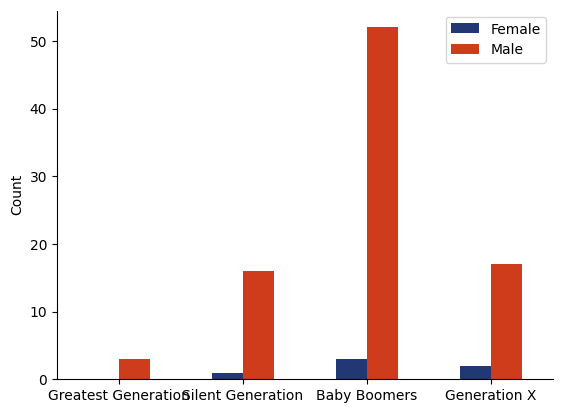

In [28]:
colors = ["#213875", "#ce3c1b"]
fig = plt.figure(figsize = (16,12))
cross_tab = pd.crosstab(unique_holders.generation, unique_holders.gender)
display(cross_tab)

ax = cross_tab.plot.bar(stacked=False, rot=0, color=colors)
plt.ylabel("Count")
plt.xlabel("")
legend = plt.legend(title="Gender")
ax.legend(labels=["Female", "Male"])

ax.spines['top'].set_color("white")
ax.spines['right'].set_color("white")

plt.show()

Text(0.5, 1.0, 'Top Categories based on Number of Transactions')

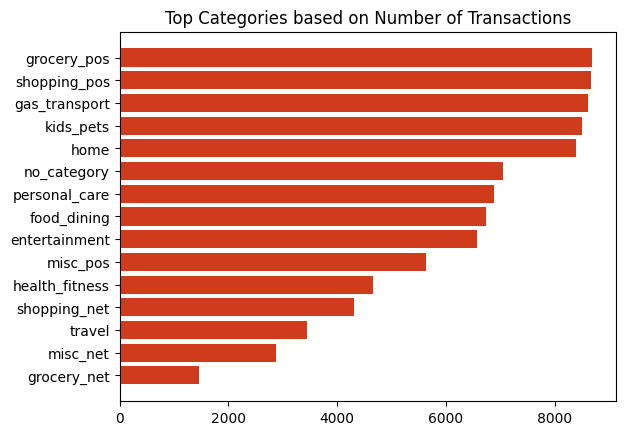

In [29]:
category_trans = df.groupby('category')['trans_datetime'].count().sort_values(ascending=True)
plt.barh(category_trans.index, category_trans, color='#ce3c1b')
plt.title("Top Categories based on Number of Transactions")

Text(0.5, 1.0, 'Top Categories based on Amount')

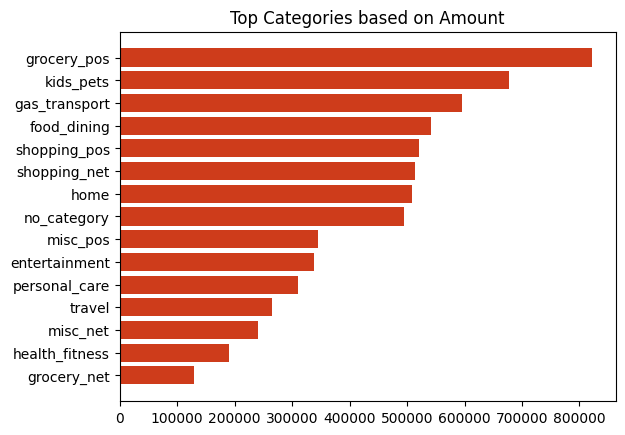

In [30]:
category_amt = df.groupby('category')['amt'].sum().sort_values(ascending=True)
plt.barh(category_amt.index, category_amt, color='#ce3c1b')
plt.title("Top Categories based on Amount")

## 3. Clustering using K Means

To learn more about the customer's behaviors, K Means will be used to cluster each user into corresponding groups based on their recency, frequency, and monetary values. To do this, we first need to get the RFM values.

In [31]:
cols = ['acct_num', 'age', 'gender']

# Getting the recency, frequency, and monetary values
rec_df = df.groupby(cols)['elapsed_days'].min().to_frame(name='recency').dropna().reset_index()
freq_df = df.groupby(cols).size().to_frame(name='freq').dropna().reset_index()
mv_df = df.groupby(cols)['amt'].sum().to_frame(name='mv').dropna().reset_index()

# Merging into one dataframe
cluster_df = pd.merge(rec_df, freq_df, how='inner', on=cols)
cluster_df = pd.merge(cluster_df, mv_df, how='inner', on=cols)

# Making sure that it was properly merge
print(len(cluster_df), len(rec_df), len(freq_df), len(mv_df))
cluster_df

94 94 94 94


,acct_num,age,gender,recency,freq,mv
0,1.240000e+11,72,M,25,1950,128213.47
1,1.380000e+11,67,M,402,6,3932.55
2,1.690000e+11,52,M,142,9,2814.60
3,1.700000e+11,66,M,25,1956,137459.29
4,2.010000e+11,56,M,26,662,48026.33
...,...,...,...,...,...,...
89,9.690000e+11,62,M,26,648,42247.66
90,9.710000e+11,79,M,25,1950,128953.65
91,9.890000e+11,73,M,26,655,46164.21
92,9.940000e+11,55,F,25,1321,84020.15


In [32]:
# if want to merge to unique_holders (or even the main dataframe)
# test = pd.merge(unique_holders, cluster_df, how='inner', on=['gender', 'acct_num', 'age'])
# test

Looking at the RFM values

array([[<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'freq'}>],
       [<Axes: title={'center': 'mv'}>, <Axes: >]], dtype=object)

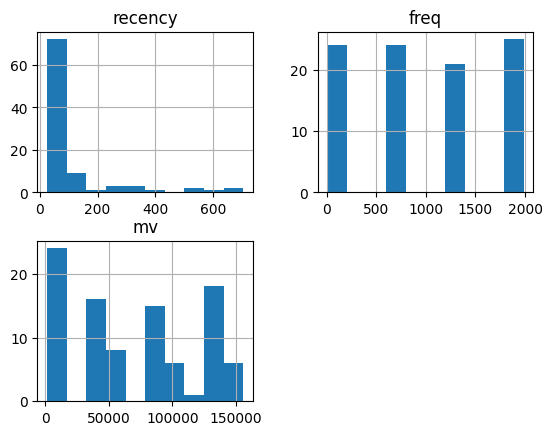

In [33]:
cluster_df.hist(['recency', 'freq', 'mv'])

In [34]:
data = cluster_df[['recency', 'freq', 'mv']]

Scaling the values using `StandardScaler`

In [35]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data

,recency,freq,mv
0,-0.441748,1.308921,1.197433
1,2.107041,-1.323325,-1.317635
2,0.349256,-1.319263,-1.340259
3,-0.441748,1.317045,1.384540
4,-0.434987,-0.435078,-0.425311
...,...,...,...
89,-0.434987,-0.454034,-0.542254
90,-0.441748,1.308921,1.212412
91,-0.434987,-0.444556,-0.462995
92,-0.441748,0.457232,0.303094


Creating functions to run K Means at different number of clusters values

In [36]:
# Function to run KMeans once
def run_kmeans(k, scaled_data):
    kmeans = KMeans(init='random', n_clusters=k, n_init=10,
                    max_iter=300, random_state=42)
    kmeans.fit(scaled_data)
    return kmeans.inertia_, kmeans.labels_


# Function to run KMeans across a range
def optimize_kmeans(cluster_range = None, scaled_data = None):
    inertias = []
    labels = []
    silhouette_values = []

    for n_clusters in cluster_range:
        inertia, label = run_kmeans(n_clusters, scaled_data)
        print(f"clusters: {n_clusters};\tinertia: {inertia}")

        inertias.append(inertia)
        labels.append(label)

        silhouette = silhouette_score(scaled_data, label)
        silhouette_values.append(silhouette)
    
    return inertias, labels, silhouette_values

In [37]:
# Test clustering from 2 to 10
clusters = range(2,11)
inertia_values, labels, sil_vals = optimize_kmeans(clusters, scaled_data)

clusters: 2;	inertia: 112.29237250186169
clusters: 3;	inertia: 47.56991025525896
clusters: 4;	inertia: 28.35574317907142
clusters: 5;	inertia: 11.114713769231074
clusters: 6;	inertia: 4.137342765757556
clusters: 7;	inertia: 3.613426870487292
clusters: 8;	inertia: 3.181996628767803
clusters: 9;	inertia: 2.866720944882057
clusters: 10;	inertia: 2.7693068174647193


Choosing the number of clusters for grouping the customers

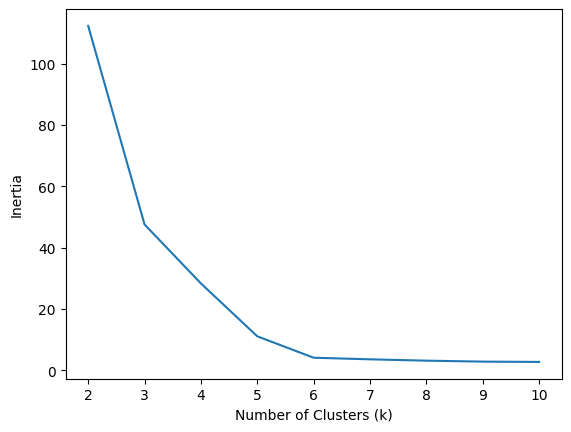

In [38]:
plt.plot(clusters, inertia_values)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [39]:
# Getting optimal k based on derivatives
differences = np.diff(inertia_values)
second_deriv = np.diff(differences)

elbow_index = np.argmax(second_deriv) + 1
print(f"Ideal number of clusters: {clusters[elbow_index]}")

Ideal number of clusters: 3


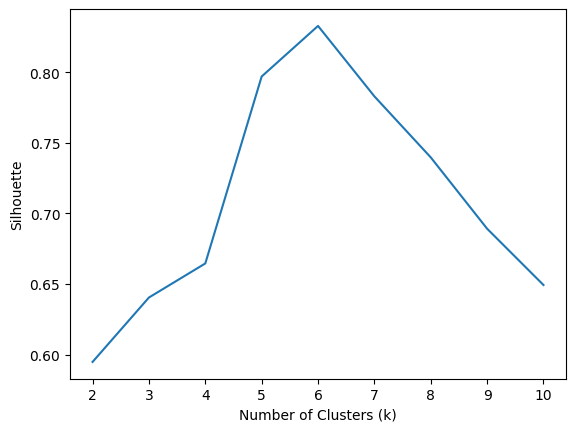

In [40]:
# Looking at silhouette values
plt.plot(clusters, sil_vals)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette")
plt.show()

Based on the two graphs above, the ideal number of cluster is either 3 (based on elbow value) or 6 (based on silhouette values). We will try both to see what the differences will be per group depending on the number of clusters.

In [41]:
inertia_three, labels_three = run_kmeans(3, scaled_data)
inertia_six, labels_six = run_kmeans(6, scaled_data)

# Putting the labels into the dataframe
data_three = data.copy()
data_three['labels'] = labels_three

data_six = data.copy()
data_six['labels'] = labels_six

In [42]:
display(data_three.head(),
        data_six.head())

,recency,freq,mv,labels
0,25,1950,128213.47,0
1,402,6,3932.55,2
2,142,9,2814.60,1
3,25,1956,137459.29,0
4,26,662,48026.33,1


,recency,freq,mv,labels
0,25,1950,128213.47,3
1,402,6,3932.55,0
2,142,9,2814.60,2
3,25,1956,137459.29,3
4,26,662,48026.33,5


In [43]:
# Comparing the general values between the groups/labels produced by 3 and 6 clusters
data_three.groupby("labels").mean()

,recency,freq,mv
labels,,,
0,25.130435,1661.673913,114489.759348
1,58.250000,441.361111,32323.690278
2,436.583333,8.833333,4987.440833


In [44]:
data_six.groupby("labels").mean()

,recency,freq,mv
labels,,,
0,316.571429,8.857143,5382.461429
1,25.142857,1309.380952,91383.461905
2,124.166667,11.166667,5136.908333
3,25.120000,1957.600000,133899.049200
4,604.600000,8.800000,4434.412000
5,25.291667,656.458333,45917.081250


Note that the "top spenders" or the best customers are those with low recency, high frequency, and high monetary value. For a more focused exploration of the customers, `k=6` will be used.

In [45]:
# Append labels of k=6 to the original data
data['labels'] = labels_six
scaled_data['labels'] = labels_six

display(data.head(),
        scaled_data.head())

,recency,freq,mv,labels
0,25,1950,128213.47,3
1,402,6,3932.55,0
2,142,9,2814.60,2
3,25,1956,137459.29,3
4,26,662,48026.33,5


,recency,freq,mv,labels
0,-0.441748,1.308921,1.197433,3
1,2.107041,-1.323325,-1.317635,0
2,0.349256,-1.319263,-1.340259,2
3,-0.441748,1.317045,1.384540,3
4,-0.434987,-0.435078,-0.425311,5


## 4. Cluster Deep Dive

### Merging

In [46]:
# First merging the labels to the cluster_df
cluster_df = pd.merge(cluster_df, data, how='inner', on=['recency', 'freq', 'mv'])
cluster_df

,acct_num,age,gender,recency,freq,mv,labels
0,1.240000e+11,72,M,25,1950,128213.47,3
1,1.380000e+11,67,M,402,6,3932.55,0
2,1.690000e+11,52,M,142,9,2814.60,2
3,1.700000e+11,66,M,25,1956,137459.29,3
4,2.010000e+11,56,M,26,662,48026.33,5
...,...,...,...,...,...,...,...
89,9.690000e+11,62,M,26,648,42247.66,5
90,9.710000e+11,79,M,25,1950,128953.65,3
91,9.890000e+11,73,M,26,655,46164.21,5
92,9.940000e+11,55,F,25,1321,84020.15,1


In [47]:
# Merging the cluster_df values into the unique_holders df
unique_holders = pd.merge(unique_holders, cluster_df, how='inner', on=['acct_num', 'gender', 'age'])
unique_holders

,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_dob,age,generation,recency,freq,mv,labels
0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,1958-12-12,63,Baby Boomers,26,657,43736.32,5
1,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,1970-08-31,51,Generation X,25,1953,127440.67,3
2,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,1953-07-23,68,Baby Boomers,25,1961,126532.58,3
3,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,1954-01-11,67,Baby Boomers,25,1947,127696.28,3
4,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,1961-07-31,60,Baby Boomers,25,1307,88066.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,M,Iloilo,447992,Land/geomatics surveyor,10/04/1969,1.690000e+11,169000000000,1969-04-10,52,Generation X,142,9,2814.60,2
90,M,Lucena,266248,Interpreter,01/06/1957,9.600000e+11,960000000000,1957-06-01,64,Baby Boomers,340,9,5657.85,0
91,M,Pagadian,199060,Land/geomatics surveyor,14/09/1961,2.360000e+11,236000000000,1961-09-14,60,Baby Boomers,147,9,7317.52,2
92,M,Marikina City,450741,Youth worker,05/09/1954,1.380000e+11,138000000000,1954-09-05,67,Baby Boomers,402,6,3932.55,0


In [48]:
# Finally merging the labels into the transactions data
df_with_label = pd.merge(df, unique_holders, how='left',on=['gender', 'city', 'city_pop', 'job', 'dob', 'acct_num', 'acct_num2', 'trans_dob', 'age', 'generation'])
df_with_label

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,...,age,generation,trans_hour,trans_month,trans_year,elapsed_days,recency,freq,mv,labels
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,...,63,Baby Boomers,5,2,2020,690,26,657,43736.32,5
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,...,51,Generation X,5,5,2020,579,25,1953,127440.67,3
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,...,68,Baby Boomers,5,3,2020,642,25,1961,126532.58,3
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,...,67,Baby Boomers,8,9,2020,459,25,1947,127696.28,3
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,...,60,Baby Boomers,4,7,2020,532,25,1307,88066.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92427,3.530000e+15,M,Dasmarinas,659019,"Physicist, medical",26/03/1965,2.010000e+11,201000000000,4f77498d91283c4910a636b2e8149dda,1587273415,...,56,Generation X,5,4,2020,621,26,662,48026.33,5
92428,2.470000e+15,M,San Fernando,306659,"Surveyor, quantity",01/11/1935,5.811000e+11,581000000000,d44f411eabd406a76a60546e723a98fd,1628185569,...,86,Silent Generation,17,8,2021,148,25,657,50099.73,5
92429,3.520000e+15,M,Masbate,95389,Wellsite geologist,20/11/1967,5.310000e+11,531000000000,7e767a74cae901c13f1a9d1d37aa63d4,1621481285,...,54,Generation X,3,5,2021,225,25,654,44542.77,5
92430,4.620000e+15,M,San Fernando,121812,Personnel officer,20/11/1934,5.550000e+11,555000000000,6ced184c93e66028e8d235ad3060de90,1625341374,...,87,Silent Generation,19,7,2021,181,25,1307,92351.49,1


In [49]:
# df_with_label.to_csv('data/s1_final_csv.csv', index=False)
# unique_holders.to_csv('data/s1_users_csv.csv', index=False)

### Analysis of Clusters

#### Description

In [50]:
unique_holders.groupby('labels')[['recency', 'freq', 'mv']].mean()

,recency,freq,mv
labels,,,
0,316.571429,8.857143,5382.461429
1,25.142857,1309.380952,91383.461905
2,124.166667,11.166667,5136.908333
3,25.120000,1957.600000,133899.049200
4,604.600000,8.800000,4434.412000
5,25.291667,656.458333,45917.081250


In [51]:
display(unique_holders['labels'].value_counts(),
        df_with_label['labels'].value_counts())

labels
3    25
5    24
1    21
2    12
0     7
4     5
Name: count, dtype: int64

labels
3    48940
1    27497
5    15755
2      134
0       62
4       44
Name: count, dtype: int64

From the table above, we will only be focusing on clusters 1, 2, 3, and 5 since they show potential to the bank. We will, for now, ignore analyzing clusters 0 and 4 as they seem to be customers who are currently highly disengaged. Disengaged customers will not be prioritized for now as the company will first need to spend resources "bringing them back" or making them engaged before the bank can try to keep them engaged. As such, it is more beneficial for the company (in terms of resources) to put more time and effort into making sure that the engaged customers spend or use their credit card more.

In analyzing each cluster, we will be comparing the average spending per category and average monthly spending across the different generations. But, we first divide the category of transactions into two parts: physical and digital transactions.

The categories considered to be part of the
1. phyiscal transactions are: `grocery_pos`, `gas_transport`, `shopping_pos`, `misc_pos`
2. digital transactions are: `grocery_net`, `shopping_net`, `misc_net`

In [52]:
display(df['category'].unique())

# Dividing the categories into physical, digital, or others
physical_cats = ['grocery_pos', 'gas_transport', 'shopping_pos', 'misc_pos']
digital_cats = ['grocery_net', 'shopping_net', 'misc_net']
other_cats = [cat for cat in df['category'].unique() if cat not in physical_cats and cat not in digital_cats]

array(['shopping_net', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'no_category', 'personal_care', 'grocery_pos',
       'travel', 'misc_net', 'health_fitness', 'shopping_pos', 'misc_pos',
       'grocery_net'], dtype=object)

We also add the category type into the dataset for easier analysis

In [53]:
def get_category_type(cat):
    if cat in physical_cats:
        return "Physical"
    elif cat in digital_cats:
        return "Digital"
    else:
        return "Others"

df_with_label['category_type'] = df_with_label['category'].map(get_category_type)
df_with_label.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,...,generation,trans_hour,trans_month,trans_year,elapsed_days,recency,freq,mv,labels,category_type
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,...,Baby Boomers,5,2,2020,690,26,657,43736.32,5,Digital
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,...,Generation X,5,5,2020,579,25,1953,127440.67,3,Others
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,...,Baby Boomers,5,3,2020,642,25,1961,126532.58,3,Others
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,...,Baby Boomers,8,9,2020,459,25,1947,127696.28,3,Physical
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,...,Baby Boomers,4,7,2020,532,25,1307,88066.84,1,Digital


#### Analysis on Cluster 1

In [54]:
unique_holders.groupby('labels')[['recency', 'freq', 'mv']].mean().iloc[1]

recency       25.142857
freq        1309.380952
mv         91383.461905
Name: 1, dtype: float64

In [55]:
# Filtering datasets to only those that are part of cluster 1
c1_trans = df_with_label[df_with_label['labels'] == 1]
c1_users = unique_holders[unique_holders['labels'] == 1]

# Checking that it is the same as the original
print(len(c1_trans), len(c1_users))

27497 21


General Info about the Customers in the Cluster

In [56]:
display(c1_users['age'].describe(),
        c1_users['generation'].value_counts())

count    21.000000
mean     66.761905
std       9.689710
min      51.000000
25%      58.000000
50%      69.000000
75%      72.000000
max      87.000000
Name: age, dtype: float64

generation
Baby Boomers           15
Silent Generation       3
Generation X            3
Greatest Generation     0
Millenials              0
Generation Z            0
Generation Alpha        0
Name: count, dtype: int64

Physical vs Digital: Average Spending per Generation

In [57]:
avg_per_gen_type = pd.pivot_table(c1_trans, values='amt', index='category_type', columns='generation')

# Turn the values into whole numbers (for plotting)
for cat in avg_per_gen_type.columns:
    avg_per_gen_type[cat] = avg_per_gen_type[cat].apply(lambda x: np.round(x))

avg_per_gen_type

generation,Silent Generation,Baby Boomers,Generation X
category_type,,,
Digital,98.0,98.0,93.0
Others,61.0,65.0,59.0
Physical,70.0,72.0,78.0


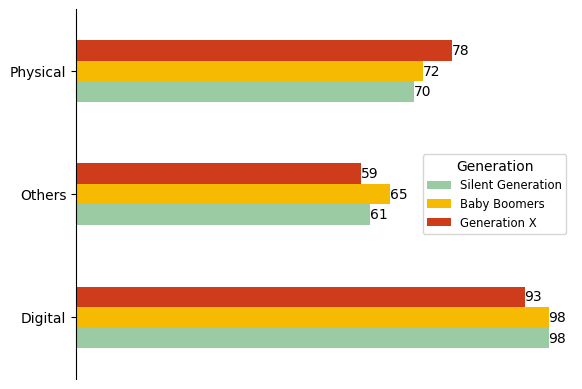

In [58]:
# Plotting
gen_colors = ["#213875", "#9acba2", "#f5ba01", "#ce3c1b"]
ax = avg_per_gen_type.plot(kind='barh', color=gen_colors[1:])

for container in ax.containers:
    ax.bar_label(container)

for spine in ['right', 'top', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')
plt.tick_params( # remove ticks on the x axis
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False
)
plt.ylabel("")
plt.show()

Category Level: Average Spending per Generation

In [59]:
avg_per_gen_cat = pd.pivot_table(c1_trans, values='amt', index='category', columns='generation')

# Turn the values into whole numbers (for plotting)
for cat in avg_per_gen_cat.columns:
    avg_per_gen_cat[cat] = avg_per_gen_cat[cat].apply(lambda x: np.round(x))

avg_per_gen_cat.index = ['Entertainment', 'Food and Dining', 'Gas Transport', 'Online Grocery', 'Physical Grocery',
                         'Health and Fitness', 'Home', 'Kids and Pets', 'Online Miscellaneous', 'Physical Miscellaneous',
                         'No Category', 'Personal Care', 'Online Shopping', 'Physical Shopping', 'Travel']
avg_per_gen_cat

generation,Silent Generation,Baby Boomers,Generation X
Entertainment,56.0,51.0,51.0
Food and Dining,81.0,81.0,81.0
Gas Transport,69.0,69.0,69.0
Online Grocery,89.0,89.0,84.0
Physical Grocery,95.0,93.0,94.0
Health and Fitness,42.0,43.0,42.0
Home,59.0,61.0,61.0
Kids and Pets,80.0,80.0,74.0
Online Miscellaneous,113.0,88.0,52.0
Physical Miscellaneous,62.0,63.0,55.0


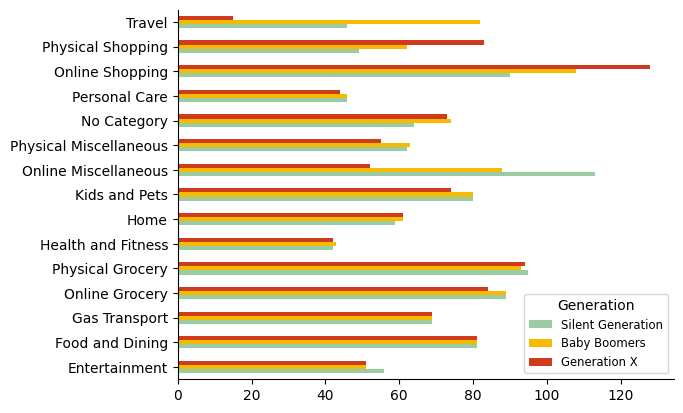

In [60]:
# Plotting
ax = avg_per_gen_cat.plot(kind='barh', color=gen_colors[1:])

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')

plt.ylabel("")
plt.show()

Average Monthly Spending

In [61]:
# Filter by Physical or Digital Category
physical_trans = c1_trans[c1_trans['category_type'] == "Physical"].sort_values(by='trans_datetime')
physical_trans = physical_trans[['trans_year', 'trans_month', 'amt']] # get specific columns
digital_trans = c1_trans[c1_trans['category_type'] == "Digital"].sort_values(by='trans_datetime')
digital_trans = digital_trans[['trans_year', 'trans_month', 'amt']]

# Filter to transactions made in 2020
physical_2020 = physical_trans[physical_trans['trans_year'] == 2020]
physical_2020 = physical_2020[['trans_month', 'amt']]
digital_2020 = digital_trans[digital_trans['trans_year'] == 2020]
digital_2020 = digital_2020[['trans_month', 'amt']]

# Filter to transactions made in 2021
physical_2021 = physical_trans[physical_trans['trans_year'] == 2021]
physical_2021 = physical_2021[['trans_month', 'amt']]
digital_2021 = digital_trans[digital_trans['trans_year'] == 2021]
digital_2021 = digital_2021[['trans_month', 'amt']]

# Get the average transactions made in 2020
phys_trans_data = physical_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data['month'] = phys_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data['date'] = pd.to_datetime(("2020 " + phys_trans_data['month']), dayfirst=True) # convert the date into year, month
phys_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data = digital_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data['month'] = dig_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data['date'] = pd.to_datetime(("2020 " + dig_trans_data['month']), dayfirst=True) # convert the date into year, month
dig_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Get the average transactions made in 2021
phys_trans_data2 = physical_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data2['month'] = phys_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data2['date'] = pd.to_datetime(("2021 " + phys_trans_data2['month']), dayfirst=True) # convert the date into year, month
phys_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data2 = digital_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data2['month'] = dig_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data2['date'] = pd.to_datetime(("2021 " + dig_trans_data2['month']), dayfirst=True) # convert the date into year, month
dig_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Combine and round the average number
phys_trans_data = pd.concat([phys_trans_data, phys_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
phys_trans_data['avg'] = phys_trans_data['avg'].apply(lambda x: round(x)) # round avg value
phys_trans_data = phys_trans_data.rename(columns={"avg": "Physical"}) # rename column
dig_trans_data = pd.concat([dig_trans_data, dig_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
dig_trans_data['avg'] = dig_trans_data['avg'].apply(lambda x: round(x)) # round avg value
dig_trans_data = dig_trans_data.rename(columns={"avg": "Digital"}) # rename column

# Combine into one dataframe
avg_trans = phys_trans_data.merge(dig_trans_data, on='date', how='inner')

# Plot
fig = px.line(avg_trans, x='date', y=['Physical', 'Digital'],
              title='Average Monthly Spending',
              color_discrete_sequence=colors,
              labels= {"variable": "Category Type"}
              )

fig.update_layout(xaxis_title="", yaxis_title="",
                  plot_bgcolor='white', paper_bgcolor='white')

fig.show()

#### Analysis on Cluster 2

In [62]:
unique_holders.groupby('labels')[['recency', 'freq', 'mv']].mean().iloc[2]

recency     124.166667
freq         11.166667
mv         5136.908333
Name: 2, dtype: float64

In [63]:
# Filtering datasets to only those that are part of cluster 2
c2_trans = df_with_label[df_with_label['labels'] == 2]
c2_users = unique_holders[unique_holders['labels'] == 2]

# Checking that it is the same as the original
print(len(c2_trans), len(c2_users))

134 12


General Info about the Customers in the Cluster

In [64]:
display(c2_users['age'].describe(),
        c2_users['generation'].value_counts())

count    12.000000
mean     71.083333
std      16.098889
min      52.000000
25%      59.500000
50%      65.500000
75%      85.500000
max      95.000000
Name: age, dtype: float64

generation
Baby Boomers           6
Greatest Generation    2
Silent Generation      2
Generation X           2
Millenials             0
Generation Z           0
Generation Alpha       0
Name: count, dtype: int64

Physical vs Digital: Average Spending per Generation

In [65]:
avg_per_gen_type = pd.pivot_table(c2_trans, values='amt', index='category_type', columns='generation')

# Turn the values into whole numbers (for plotting)
for cat in avg_per_gen_type.columns:
    avg_per_gen_type[cat] = avg_per_gen_type[cat].apply(lambda x: np.round(x))

avg_per_gen_type

generation,Greatest Generation,Silent Generation,Baby Boomers,Generation X
category_type,,,,
Digital,885.0,796.0,830.0,897.0
Others,20.0,365.0,96.0,968.0
Physical,704.0,456.0,275.0,154.0


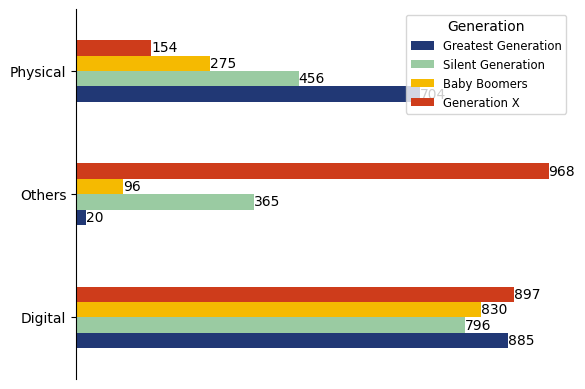

In [66]:
# Plotting
ax = avg_per_gen_type.plot(kind='barh', color=gen_colors)

for container in ax.containers:
    ax.bar_label(container)

for spine in ['right', 'top', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False
)

plt.ylabel("")
plt.show()

Category Level: Average Spending per Generation

In [67]:
avg_per_gen_cat = pd.pivot_table(c2_trans, values='amt', index='category', columns='generation')

for cat in avg_per_gen_cat.columns:
    avg_per_gen_cat[cat] = avg_per_gen_cat[cat].apply(lambda x: np.round(x))

avg_per_gen_cat.index = ['Entertainment', 'Food and Dining', 'Gas Transport', 'Online Grocery', 'Physical Grocery',
                         'Health and Fitness', 'Home', 'Kids and Pets', 'Online Miscellaneous', 'Physical Miscellaneous',
                         'No Category', 'Personal Care', 'Online Shopping', 'Physical Shopping', 'Travel']

avg_per_gen_cat.fillna(0, inplace=True)
avg_per_gen_cat

generation,Greatest Generation,Silent Generation,Baby Boomers,Generation X
Entertainment,0.0,0.0,48.0,0.0
Food and Dining,0.0,0.0,82.0,0.0
Gas Transport,7.0,0.0,53.0,9.0
Online Grocery,0.0,0.0,11.0,0.0
Physical Grocery,317.0,298.0,267.0,298.0
Health and Fitness,0.0,24.0,23.0,0.0
Home,0.0,0.0,110.0,0.0
Kids and Pets,20.0,0.0,80.0,0.0
Online Miscellaneous,818.0,796.0,817.0,809.0
Physical Miscellaneous,0.0,0.0,9.0,8.0


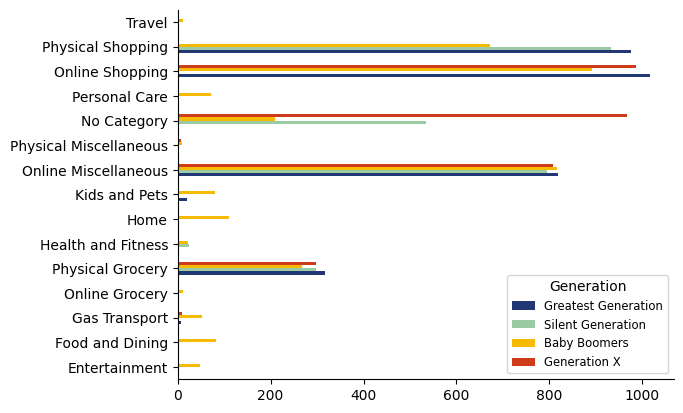

In [68]:
# Plotting
ax = avg_per_gen_cat.plot(kind='barh', color=gen_colors)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')

plt.ylabel("")
plt.show()

Average Monthly Spending

In [69]:
# Filter by Physical or Digital Category
physical_trans = c2_trans[c2_trans['category_type'] == "Physical"].sort_values(by='trans_datetime')
physical_trans = physical_trans[['trans_year', 'trans_month', 'amt']] # get specific columns
digital_trans = c2_trans[c2_trans['category_type'] == "Digital"].sort_values(by='trans_datetime')
digital_trans = digital_trans[['trans_year', 'trans_month', 'amt']]

# Filter to transactions made in 2020
physical_2020 = physical_trans[physical_trans['trans_year'] == 2020]
physical_2020 = physical_2020[['trans_month', 'amt']]
digital_2020 = digital_trans[digital_trans['trans_year'] == 2020]
digital_2020 = digital_2020[['trans_month', 'amt']]

# Filter to transactions made in 2021
physical_2021 = physical_trans[physical_trans['trans_year'] == 2021]
physical_2021 = physical_2021[['trans_month', 'amt']]
digital_2021 = digital_trans[digital_trans['trans_year'] == 2021]
digital_2021 = digital_2021[['trans_month', 'amt']]

# Get the average transactions made in 2020
phys_trans_data = physical_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data['month'] = phys_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data['date'] = pd.to_datetime(("2020 " + phys_trans_data['month']), dayfirst=True) # convert the date into year, month
phys_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data = digital_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data['month'] = dig_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data['date'] = pd.to_datetime(("2020 " + dig_trans_data['month']), dayfirst=True) # convert the date into year, month
dig_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Get the average transactions made in 2021
phys_trans_data2 = physical_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data2['month'] = phys_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data2['date'] = pd.to_datetime(("2021 " + phys_trans_data2['month']), dayfirst=True) # convert the date into year, month
phys_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data2 = digital_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data2['month'] = dig_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data2['date'] = pd.to_datetime(("2021 " + dig_trans_data2['month']), dayfirst=True) # convert the date into year, month
dig_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Combine and round the average number
phys_trans_data = pd.concat([phys_trans_data, phys_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
phys_trans_data['avg'] = phys_trans_data['avg'].apply(lambda x: round(x)) # round avg value
phys_trans_data = phys_trans_data.rename(columns={"avg": "Physical"}) # rename column
dig_trans_data = pd.concat([dig_trans_data, dig_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
dig_trans_data['avg'] = dig_trans_data['avg'].apply(lambda x: round(x)) # round avg value
dig_trans_data = dig_trans_data.rename(columns={"avg": "Digital"}) # rename column

# Combine into one dataframe
avg_trans = phys_trans_data.merge(dig_trans_data, on='date', how='inner')

# Plot
fig = px.line(avg_trans, x='date', y=['Physical', 'Digital'],
              title='Average Monthly Spending',
              color_discrete_sequence=colors,
              labels= {"variable": "Category Type"}
              )

fig.update_layout(xaxis_title="", yaxis_title="",
                  plot_bgcolor='white', paper_bgcolor='white')

fig.show()

#### Analysis on Cluster 3

In [70]:
unique_holders.groupby('labels')[['recency', 'freq', 'mv']].mean().iloc[3]

recency        25.1200
freq         1957.6000
mv         133899.0492
Name: 3, dtype: float64

In [71]:
# Filtering datasets to only those that are part of cluster 3
c3_trans = df_with_label[df_with_label['labels'] == 3]
c3_users = unique_holders[unique_holders['labels'] == 3]

# Checking that it is the same as the original
print(len(c3_trans), len(c3_users))

48940 25


General Info about the Customers in the Cluster

In [72]:
display(c3_users['age'].describe(),
        c3_users['generation'].value_counts())

count    25.000000
mean     65.680000
std      10.172348
min      51.000000
25%      59.000000
50%      64.000000
75%      72.000000
max      91.000000
Name: age, dtype: float64

generation
Baby Boomers           15
Silent Generation       5
Generation X            5
Greatest Generation     0
Millenials              0
Generation Z            0
Generation Alpha        0
Name: count, dtype: int64

Physical vs Digital: Average Spending per Generation

In [73]:
avg_per_gen_type = pd.pivot_table(c3_trans, values='amt', index='category_type', columns='generation')

# Turn the values into whole numbers (for plotting)
for cat in avg_per_gen_type.columns:
    avg_per_gen_type[cat] = avg_per_gen_type[cat].apply(lambda x: np.round(x))

avg_per_gen_type

generation,Silent Generation,Baby Boomers,Generation X
category_type,,,
Digital,94.0,87.0,88.0
Others,63.0,65.0,63.0
Physical,71.0,70.0,69.0


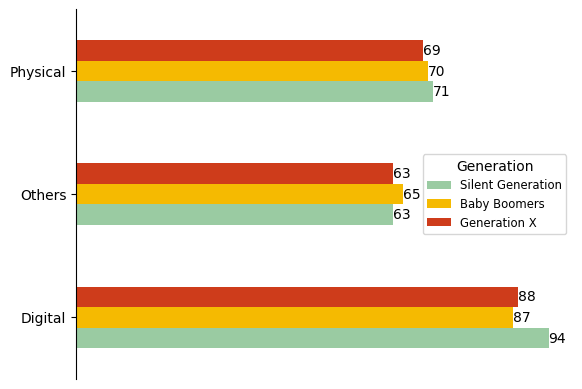

In [74]:
# Plotting
ax = avg_per_gen_type.plot(kind='barh', color=gen_colors[1:])

for container in ax.containers:
    ax.bar_label(container)

for spine in ['right', 'top', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False
)

plt.ylabel("")
plt.show()

Category Level: Average Spending per Generation

In [75]:
avg_per_gen_cat = pd.pivot_table(c3_trans, values='amt', index='category', columns='generation')

for cat in avg_per_gen_cat.columns:
    avg_per_gen_cat[cat] = avg_per_gen_cat[cat].apply(lambda x: np.round(x))

avg_per_gen_cat.index = ['Entertainment', 'Food and Dining', 'Gas Transport', 'Online Grocery', 'Physical Grocery',
                         'Health and Fitness', 'Home', 'Kids and Pets', 'Online Miscellaneous', 'Physical Miscellaneous',
                         'No Category', 'Personal Care', 'Online Shopping', 'Physical Shopping', 'Travel']

avg_per_gen_cat

generation,Silent Generation,Baby Boomers,Generation X
Entertainment,48.0,54.0,52.0
Food and Dining,80.0,81.0,81.0
Gas Transport,68.0,70.0,69.0
Online Grocery,87.0,91.0,87.0
Physical Grocery,92.0,93.0,91.0
Health and Fitness,38.0,40.0,43.0
Home,60.0,60.0,62.0
Kids and Pets,79.0,80.0,80.0
Online Miscellaneous,65.0,59.0,75.0
Physical Miscellaneous,71.0,61.0,60.0


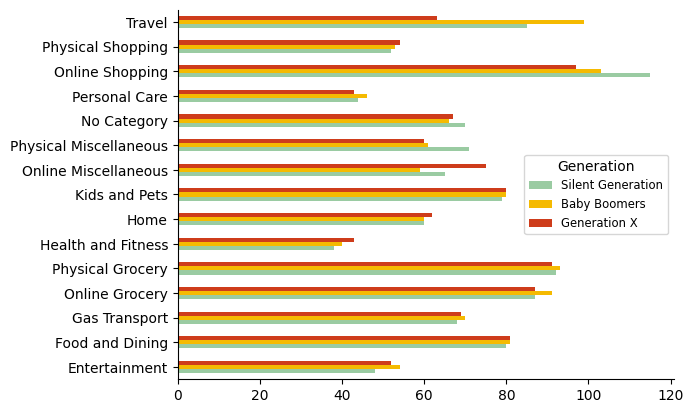

In [76]:
# Plotting
ax = avg_per_gen_cat.plot(kind='barh', color=gen_colors[1:])

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')

plt.ylabel("")
plt.show()

Average Monthly Spending

In [77]:
# Filter by Physical or Digital Category
physical_trans = c3_trans[c3_trans['category_type'] == "Physical"].sort_values(by='trans_datetime')
physical_trans = physical_trans[['trans_year', 'trans_month', 'amt']] # get specific columns
digital_trans = c3_trans[c3_trans['category_type'] == "Digital"].sort_values(by='trans_datetime')
digital_trans = digital_trans[['trans_year', 'trans_month', 'amt']]

# Filter to transactions made in 2020
physical_2020 = physical_trans[physical_trans['trans_year'] == 2020]
physical_2020 = physical_2020[['trans_month', 'amt']]
digital_2020 = digital_trans[digital_trans['trans_year'] == 2020]
digital_2020 = digital_2020[['trans_month', 'amt']]

# Filter to transactions made in 2021
physical_2021 = physical_trans[physical_trans['trans_year'] == 2021]
physical_2021 = physical_2021[['trans_month', 'amt']]
digital_2021 = digital_trans[digital_trans['trans_year'] == 2021]
digital_2021 = digital_2021[['trans_month', 'amt']]

# Get the average transactions made in 2020
phys_trans_data = physical_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data['month'] = phys_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data['date'] = pd.to_datetime(("2020 " + phys_trans_data['month']), dayfirst=True) # convert the date into year, month
phys_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data = digital_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data['month'] = dig_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data['date'] = pd.to_datetime(("2020 " + dig_trans_data['month']), dayfirst=True) # convert the date into year, month
dig_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Get the average transactions made in 2021
phys_trans_data2 = physical_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data2['month'] = phys_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data2['date'] = pd.to_datetime(("2021 " + phys_trans_data2['month']), dayfirst=True) # convert the date into year, month
phys_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data2 = digital_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data2['month'] = dig_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data2['date'] = pd.to_datetime(("2021 " + dig_trans_data2['month']), dayfirst=True) # convert the date into year, month
dig_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Combine and round the average number
phys_trans_data = pd.concat([phys_trans_data, phys_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
phys_trans_data['avg'] = phys_trans_data['avg'].apply(lambda x: round(x)) # round avg value
phys_trans_data = phys_trans_data.rename(columns={"avg": "Physical"}) # rename column
dig_trans_data = pd.concat([dig_trans_data, dig_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
dig_trans_data['avg'] = dig_trans_data['avg'].apply(lambda x: round(x)) # round avg value
dig_trans_data = dig_trans_data.rename(columns={"avg": "Digital"}) # rename column

# Combine into one dataframe
avg_trans = phys_trans_data.merge(dig_trans_data, on='date', how='inner')

# Plot
fig = px.line(avg_trans, x='date', y=['Physical', 'Digital'],
              title='Average Monthly Spending',
              color_discrete_sequence=colors,
              labels= {"variable": "Category Type"}
              )

fig.update_layout(xaxis_title="", yaxis_title="",
                  plot_bgcolor='white', paper_bgcolor='white')

fig.show()

#### Analysis on Cluster 5

In [78]:
unique_holders.groupby('labels')[['recency', 'freq', 'mv']].mean().iloc[5]

recency       25.291667
freq         656.458333
mv         45917.081250
Name: 5, dtype: float64

In [79]:
# Filtering datasets to only those that are part of cluster 5
c5_trans = df_with_label[df_with_label['labels'] == 5]
c5_users = unique_holders[unique_holders['labels'] == 5]

# Checking that it is the same as the original
print(len(c5_trans), len(c5_users))

15755 24


General Info about the Customers in the Cluster

In [80]:
display(c5_users['age'].describe(),
        c5_users['generation'].value_counts())

count    24.000000
mean     68.291667
std      13.366015
min      51.000000
25%      56.000000
50%      64.500000
75%      76.750000
max      95.000000
Name: age, dtype: float64

generation
Baby Boomers           10
Generation X            7
Silent Generation       6
Greatest Generation     1
Millenials              0
Generation Z            0
Generation Alpha        0
Name: count, dtype: int64

Physical vs Digital: Average Spending per Generation

In [81]:
avg_per_gen_type = pd.pivot_table(c5_trans, values='amt', index='category_type', columns='generation')

# Turn the values into whole numbers (for plotting)
for cat in avg_per_gen_type.columns:
    avg_per_gen_type[cat] = avg_per_gen_type[cat].apply(lambda x: np.round(x))

avg_per_gen_type

generation,Greatest Generation,Silent Generation,Baby Boomers,Generation X
category_type,,,,
Digital,113.0,120.0,105.0,109.0
Others,85.0,60.0,59.0,63.0
Physical,65.0,73.0,72.0,75.0


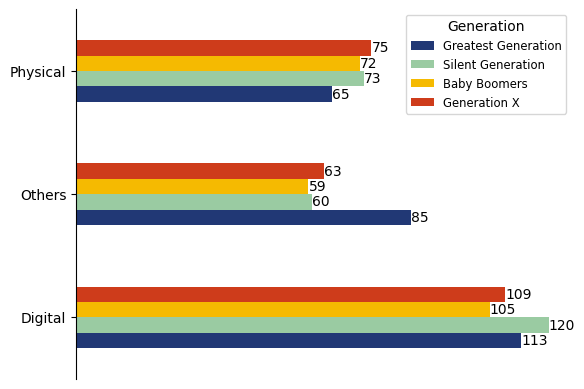

In [82]:
# Plotting
ax = avg_per_gen_type.plot(kind='barh', color=gen_colors)

for container in ax.containers:
    ax.bar_label(container)

for spine in ['right', 'top', 'bottom']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False
)

plt.ylabel("")
plt.show()

Category Level: Average Spending per Generation

In [83]:
avg_per_gen_cat = pd.pivot_table(c5_trans, values='amt', index='category', columns='generation')

for cat in avg_per_gen_cat.columns:
    avg_per_gen_cat[cat] = avg_per_gen_cat[cat].apply(lambda x: np.round(x))

avg_per_gen_cat.index = ['Entertainment', 'Food and Dining', 'Gas Transport', 'Online Grocery', 'Physical Grocery',
                         'Health and Fitness', 'Home', 'Kids and Pets', 'Online Miscellaneous', 'Physical Miscellaneous',
                         'No Category', 'Personal Care', 'Online Shopping', 'Physical Shopping', 'Travel']

avg_per_gen_cat

generation,Greatest Generation,Silent Generation,Baby Boomers,Generation X
Entertainment,55.0,44.0,48.0,52.0
Food and Dining,82.0,69.0,84.0,82.0
Gas Transport,64.0,69.0,69.0,70.0
Online Grocery,91.0,91.0,88.0,86.0
Physical Grocery,100.0,96.0,100.0,97.0
Health and Fitness,33.0,43.0,39.0,40.0
Home,74.0,57.0,59.0,60.0
Kids and Pets,90.0,78.0,81.0,81.0
Online Miscellaneous,53.0,108.0,70.0,96.0
Physical Miscellaneous,45.0,65.0,58.0,52.0


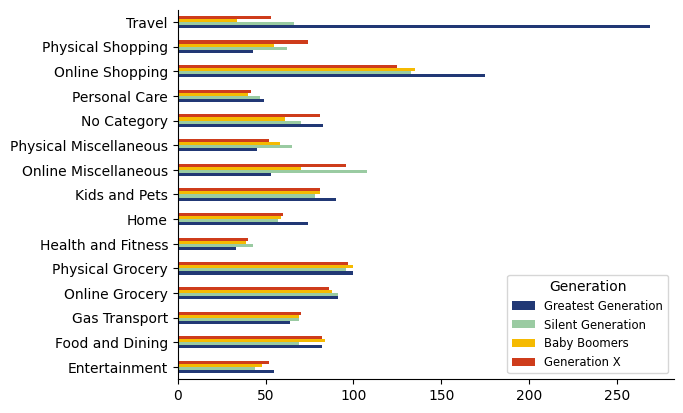

In [84]:
# Plotting
ax = avg_per_gen_cat.plot(kind='barh', color=gen_colors)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.legend(title='Generation', fontsize='small')

plt.ylabel("")
plt.show()

Average Monthly Spending

In [85]:
# Filter by Physical or Digital Category
physical_trans = c5_trans[c5_trans['category_type'] == "Physical"].sort_values(by='trans_datetime')
physical_trans = physical_trans[['trans_year', 'trans_month', 'amt']] # get specific columns
digital_trans = c5_trans[c5_trans['category_type'] == "Digital"].sort_values(by='trans_datetime')
digital_trans = digital_trans[['trans_year', 'trans_month', 'amt']]

# Filter to transactions made in 2020
physical_2020 = physical_trans[physical_trans['trans_year'] == 2020]
physical_2020 = physical_2020[['trans_month', 'amt']]
digital_2020 = digital_trans[digital_trans['trans_year'] == 2020]
digital_2020 = digital_2020[['trans_month', 'amt']]

# Filter to transactions made in 2021
physical_2021 = physical_trans[physical_trans['trans_year'] == 2021]
physical_2021 = physical_2021[['trans_month', 'amt']]
digital_2021 = digital_trans[digital_trans['trans_year'] == 2021]
digital_2021 = digital_2021[['trans_month', 'amt']]

# Get the average transactions made in 2020
phys_trans_data = physical_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data['month'] = phys_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data['date'] = pd.to_datetime(("2020 " + phys_trans_data['month']), dayfirst=True) # convert the date into year, month
phys_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data = digital_2020.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data['month'] = dig_trans_data['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data['date'] = pd.to_datetime(("2020 " + dig_trans_data['month']), dayfirst=True) # convert the date into year, month
dig_trans_data.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Get the average transactions made in 2021
phys_trans_data2 = physical_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
phys_trans_data2['month'] = phys_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
phys_trans_data2['date'] = pd.to_datetime(("2021 " + phys_trans_data2['month']), dayfirst=True) # convert the date into year, month
phys_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

dig_trans_data2 = digital_2021.groupby('trans_month')['amt'].mean().to_frame(name='avg').reset_index() # group the transactions by month and get the avg
dig_trans_data2['month'] = dig_trans_data2['trans_month'].apply(lambda x: calendar.month_name[x]) # get the month name
dig_trans_data2['date'] = pd.to_datetime(("2021 " + dig_trans_data2['month']), dayfirst=True) # convert the date into year, month
dig_trans_data2.drop(columns=['trans_month', 'month'], axis=1, inplace=True) # drop the other columns

# Combine and round the average number
phys_trans_data = pd.concat([phys_trans_data, phys_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
phys_trans_data['avg'] = phys_trans_data['avg'].apply(lambda x: round(x)) # round avg value
phys_trans_data = phys_trans_data.rename(columns={"avg": "Physical"}) # rename column
dig_trans_data = pd.concat([dig_trans_data, dig_trans_data2], ignore_index=True) # combine the avg transactions made in 2020 and 2021
dig_trans_data['avg'] = dig_trans_data['avg'].apply(lambda x: round(x)) # round avg value
dig_trans_data = dig_trans_data.rename(columns={"avg": "Digital"}) # rename column

# Combine into one dataframe
avg_trans = phys_trans_data.merge(dig_trans_data, on='date', how='inner')

# Plot
fig = px.line(avg_trans, x='date', y=['Physical', 'Digital'],
              title='Average Monthly Spending',
              color_discrete_sequence=colors,
              labels= {"variable": "Category Type"}
              )

fig.update_layout(xaxis_title="", yaxis_title="",
                  plot_bgcolor='white', paper_bgcolor='white')

fig.show()

### Summary of Findings

**Cluster 1** (Cyber Savvy Shoppers)
- composed of 21 users and 27497 transactions
    - min age of 51, max age of 87, and mean age of 66 years old
    - mostly composed of Baby Boomers (15 of the 21) and then the remaining are from the Silent Generation (3) and Generation X (3)
- High Recency (25), High Frequency (1309), High Monetary Value (91383)
- Across the generations, the average spending on digital transactions are 1.2 to 1.4 times higher than physical transactions
    - Overall, 1.31x higher than physical transactions
- In terms of specific categories, the generations spend more on digital categories over their physical counterparts. Particularly, Generation X and Baby Boomers spend more on Online Shopping over Physical Shopping while the Silent Generation spends more on Online Miscellaneous items over its Physical counterpart.
- Overall, the average monthly spending on digital categories across the transaction history timeline is higher than the physical categories, especially in the month of October.

**Cluster 2** (Epic Comeback Connoisseurs)
- composed of 12 users and 134 transactions
    - min age of 52, max age of 95, and mean age of 71 years old
    - mostly composed of Baby Boomers (6 of the 12) while the remaining are from the Greatest Generation (2), Silent Generation (2), and Generation X (2)
- Medium Recency (124), Low Frequency (11), Low Monetary Value (5136)
- Across the generations, the average spending on digital transactions are 1.26 to 5.82 times higher than physical transactions
    - Overall, 2.85x higher than physical transactions
- The categories Online Miscellaneous and Online Shopping generally have higher average spending.
- Overall, the average monthly spending on digital categories across the transaction history timeline is higher than the physical categories but with a noticable decreasing trend in 2020 going towards 2021.

**Cluster 3** (Digital Dynamos)
- composed of 25 users and 48490 transactions
    - min age of 51, max age of 91, and mean age of 65 years old
    - mostly composed of Baby Boomers (15 of the 25) and then the remaining are from the Silent Generation (5) and Generation X (5)
- High Recency (25), High Frequency (1957), High Monetary Value (133899)
- Across the generations, the average spending on digital transactions are 1.28 to 1.31 times higher than physical transactions
    - Overall, 1.28x higher than physical transactions
- In terms of specific categories, all generations have a higher average spending on online shopping and travel.
- Overall, the average monthly spending on digital categories across the transaction history timeline is higher than the physical categories

**Cluster 5** (Festive Spenders)
- composed of 24 users and 15755 transactions
    - min age of 51, max age of 95, and mean age of 68 years old
    - mostly composed of Baby Boomers (10) while the remaining are Generation X (7), Silent Generation (6), and Greatest Generation (1)
- High Recency (25), Medium Frequency (656), Medium Monetary Value (45917)
- Across the generations, the average spending on digital transactions are 1.45 to 1.74 times higher than physical transactions
    - Overall, 1.72x higher than physical transactions
- In terms of specific categories, the Greatest Generation spends the most in the travel category. For the other categories, the categories Online Shopping and Online Miscellaneous have higher average spending over its physical counterparts.
- Overall, the average monthly spending on digital categories across the transaction history timeline is higher than the physical categories, especially in 2021.